<a href="https://colab.research.google.com/github/caperock/BenchmarkDeepLearning/blob/master/dog_data_vis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install vit-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 4.4 MB/s 


In [4]:
!pip -q install vit_pytorch linformer

from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT

print(f"Torch: {torch.__version__}")

Torch: 1.12.1+cu113


In [5]:
# Training settings
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

device = 'cuda'

In [6]:
os.chdir('/content/drive/MyDrive/dog_data')
os.makedirs('data', exist_ok=True)

train_dir = 'data/train'
test_dir = 'data/test'



In [ ]:
with zipfile.ZipFile('train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile('test.zip') as test_zip:
    test_zip.extractall('data')


train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [7]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

Train Data: 25000
Test Data: 12500


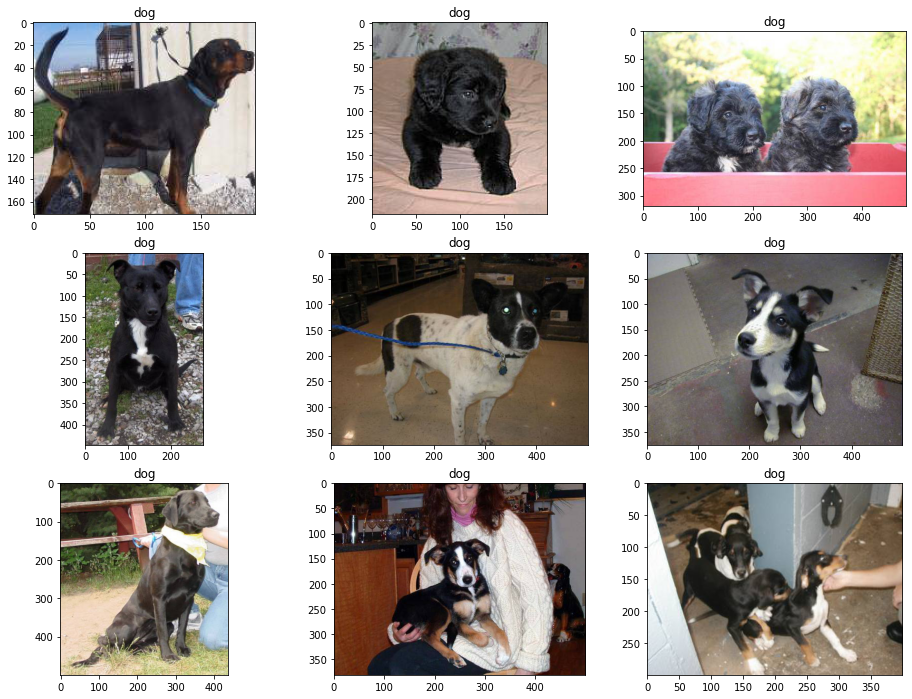

In [9]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [10]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [11]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [20]:
def crop_my_image(image: Image.Image) -> Image.Image:
    img1 = image.resize((224,224))
    im = np.array(img1.convert('L'))   
    
    M = im.shape[0]//7
    N = im.shape[1]//7
    tiles = [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]

    #for k in range(len(tiles)):
    #  img2 = Image.fromarray(tiles[k].astype('uint8'))
      
    #  img2.save("d" +str(k) +".jpg" )    


    #img2 = Image.fromarray(magnitude_init.astype('uint8'))
    #img2.save("d0.jpg" )
    current_y = 0 # keep track of where your current image was last placed in the y coordinate
    fq_image = np.zeros((7*7*32,32),dtype=np.uint8)
     
    print(len(tiles))

    for i in range(len(tiles)):  
      try:          
        f = np.fft.fft2(tiles[i])
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20*np.log(np.abs(fshift))
      except Exception as inst:
        print(i, tiles[i].shape, inst)
        magnitude_spectrum = np.zeros((32,32),dtype=np.uint8)
        print(magnitude_spectrum.shape)            
      
      fq_image[current_y:current_y+32, :32]= magnitude_spectrum
      current_y +=32
        
    fq_image = np.reshape(fq_image, (224,224))         
    img2 = Image.fromarray(fq_image.astype('uint8'))

    img2.save("dx.jpg" )
    img2 = Image.open("dx.jpg").convert('RGB')
    merged_image = np.concatenate((img1, img2), axis = 1)
    Image.fromarray(merged_image.astype('uint8'), 'RGB').save("dy.jpg" )
    
      
  
    
    #Image.fromarray(img2.astype('uint8'), 'RGB').resize((448,448)).save("c.jpg" )

    
    return img2#Image.fromarray(img2.astype('uint8'), 'RGB')

train_transforms = transforms.Compose(
    [   
        
        transforms.Lambda(crop_my_image),  
        #transforms.Resize((224, 224)),     
        transforms.Resize((448, 448)),     
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        
    ]
)

val_transforms = transforms.Compose(
    [      
        transforms.Lambda(crop_my_image),  
        transforms.Resize((448, 448)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        
    ]
)


test_transforms = transforms.Compose(
    [        
        transforms.Lambda(crop_my_image),  
        transforms.Resize((448, 448)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        
    ]
)

In [21]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0

        return img_transformed, label

In [22]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [23]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [24]:
efficient_transformer = Linformer(
    dim=128,
    #seq_len=49+1,  # 7x7 patches + 1 cls-token
    seq_len=196+1,  # 14x14 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [25]:
model = ViT(
    dim=128,
    image_size=448,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [26]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
#optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=5e-4, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [27]:

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/313 [00:00<?, ?it/s]

49


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
4

KeyboardInterrupt: ignored

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17778801266172859236
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16139419648
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 895182852472240383
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]